In [21]:
import os
import numpy as np
import pandas as pd
import setuptools
try:
    import ROOT
    import root_numpy
except ImportError as e:
    warnings.warn("Error importing ROOT-related libraries: %s. "
                  "If you try to use ROOT-related functions, hax will crash!" % e)

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Hist1d, Histdd

from scipy.optimize import curve_fit
import scipy.stats as sps
%matplotlib inline

matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['image.cmap'] = 'viridis'


In [29]:
path = "/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/"
path3="/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/"
#path1 = "/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/"
path2= "/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/"
path1= "/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/" 
#board=0
#channel=3
os.listdir(path)

['processed_wf0_Gain0_Test_standard_600_300_600.root',
 'processed_wf4_Gain0_Test_standard_600_300_600.root',
 'processed_wf0_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain0_Test_standard_600_300_600.root',
 'processed_wf3_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain1_Test_standard_600_300_600.root',
 'processed_wf3_Gain1_Test_standard_600_300_600.root',
 'processed_wf4_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain0_Test_standard_600_300_600.root',
 'processed_wf6_Gain1_Test_standard_600_300_600.root',
 'processed_wf6_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain0_Test_standard_600_300_600.root',
 'Figs']

In [23]:
os.listdir(path1)

['processed_wf0_Gain0_Test_standard_600_300_600.root',
 'processed_wf4_Gain0_Test_standard_600_300_600.root',
 'processed_wf0_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain0_Test_standard_600_300_600.root',
 'processed_wf3_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain1_Test_standard_600_300_600.root',
 'processed_wf3_Gain1_Test_standard_600_300_600.root',
 'processed_wf4_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain0_Test_standard_600_300_600.root',
 'processed_wf6_Gain1_Test_standard_600_300_600.root',
 'processed_wf6_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain0_Test_standard_600_300_600.root']

In [24]:
os.listdir(path2)

['processed_wf0_Gain0_Test_standard_600_300_600.root',
 'processed_wf4_Gain0_Test_standard_600_300_600.root',
 'processed_wf0_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain0_Test_standard_600_300_600.root',
 'processed_wf3_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain1_Test_standard_600_300_600.root',
 'processed_wf3_Gain1_Test_standard_600_300_600.root',
 'processed_wf4_Gain1_Test_standard_600_300_600.root',
 'processed_wf2_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain1_Test_standard_600_300_600.root',
 'processed_wf5_Gain0_Test_standard_600_300_600.root',
 'processed_wf6_Gain1_Test_standard_600_300_600.root',
 'processed_wf6_Gain0_Test_standard_600_300_600.root',
 'processed_wf1_Gain0_Test_standard_600_300_600.root']

In [25]:
elem_charge = 1.6021766e-19

def area_to_charge(a):
    # area in adc counts * 10 * ns
    factor = 2.25 * 10e-9 / (2**14 * 50) #  * elem_charge)
    return factor * (a / 10)

In [26]:
def process_ap_file(filename):
    #print("ok")
    file = ROOT.TFile(filename)
    #print("ok2")
    tree = file.Get('T1')
    #print("ok3")
    #pos = []
    area = []
    entropy = []

    #df = pd.DataFrame.from_records(root_numpy.root2array(filename).view(np.recarray),columns=["Area","Entropy", "Position"], coerce_float=True)
    
    #print(df.head())
    for event in tree:
        
        #
        #for p in event.Position:
         #   pos.append(p)
        if len(event.Area) > 0:
            for a in event.Area:
                area.append(a)
        if len(event.Entropy) > 0:        
            for e in event.Entropy:
                entropy.append(e)

    d = {#'time': np.array(pos),
        'area': np.array(area),
        'entropy': np.array(entropy)}
        
    df = pd.DataFrame(d)
    return df 

In [30]:
def fit_doubleGauss(x, N, sigma, mu, N2):
    return N*np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma)) + N2*np.exp(-(x-2*mu)*(x-2*mu)/(4*sigma*sigma))

def plot1dhist(data_frame,df1,df2,df3,pmt,func):
    plt.figure(figsize=(10,6))
    #data_frame1=data_frame[(data_frame['area']<50)]
    #weights = np.ones_like(data_frame1['time'])/float(len(data_frame['time'])) # normalized to ALL events (above 2pe th.)
    #plt.colorbar(label='counts')
    #bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    #plt.hist( data_frame['area'], bins=550, range=((-50, 500)), normed = False, log = True,histtype='step', label='220-300-220 standard window 175-215')#, weights = weights) #norm=LogNorm()) #bins 200
  
    plt.hist( data_frame['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False, label='600-300-600 window 217-260')
    plt.hist( df1['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False , label = '600-300-600 w 217-260 thr1&5 sigma')
    plt.hist( df2['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False, label='600-300-600 w 217-260 Alfredo method', color = 'orange')
    plt.hist( df3['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False, label='600-300-600 w 217-260 Alfredo method int samples 3-10', color = 'black', linestyle = 'solid')

    plt.xlabel('Area')
    plt.ylabel('counts')
    plt.title('PMT %d' % pmt)
    df1_cut=df1[(df1['entropy']<0.9)]
    #plt.hist( df1_cut['area'], bins=490, range=((10, 500)), normed = False, log = True,histtype='step', stacked = False, label='old Warp, entropy<0.9')
    #plt.plot(bin_centres, func(bin_centres, *res[0]))
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_noth_run2_gas.png' % pmt, dpi=150)
    data_frame1=df2[(df2['entropy']<0.8)]
    plt.hist( data_frame1['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False, label = 'Alfredo method int samples 4-6, entropy<0.8', color = 'magenta')
    """
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    D={'height': np.array(h),
      'bin_centres': np.array(bin_centres)}
    histDF=pd.DataFrame(D)
    
    peak = np.max(histDF[(histDF['bin_centres']>100)].height)
    print(peak)
    if peak == histDF.bin_centres[101].height:
        histDF=histDF[(histDF['bin_centres']>50)&(histDF['bin_centres']<350)] #define the range of fitting
    else:
        histDF=histDF[(histDF['bin_centres']>120)&(histDF['bin_centres']<350)] #define the range of fitting
    
    histDF=histDF[(histDF['bin_centres']>120)&(histDF['bin_centres']<350)] #define the range of fitting
    h1=np.array(histDF['height'])
    bin_centers= np.array(histDF['bin_centres'])
    res = curve_fit(func, bin_centers, h1, p0=[10000,100, 180, 5000])
    plt.plot(bin_centres, func(bin_centres, *res[0]))
    print(res)
    perr = np.sqrt(np.diag(res[1]))
    print(perr)
    """
    data_frame2=df3[(df3['entropy']<0.8)]
    plt.hist( data_frame2['area'], bins=850, range=((-50, 800)), normed = False, log = True,histtype='step', stacked = False, label = 'Alfredo method int samples 3-10, entropy<0.8', color = 'brown')
    plt.legend(loc = 'upper right', prop={'size': 6})
    plt.savefig(path+'Figs/'+'gain_pmt%d_run5_liquid_studies.png' % pmt, dpi=150, transparent = False)
    plt.show()
    plt.clf()
    
    """residuals = h - func(bin_centres, *res[0])
    plt.plot(bin_centres,residuals)
    plt.title('PMT %d - exp-fit residuals' %pmt)
    plt.xlabel('Time [$\mu$s]')
    plt.ylabel('Residuals')
    axes = plt.gca()
    axes.set_ylim([-100,200])
    #plt.savefig(path+'AP_figs/'+'ap_pmt%d_profile_expfit_residuals_run2_gas.png' % pmt, dpi=150)
    plt.show()
    """

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf0_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf0_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf0_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf0_Gain0_Test_standard_600_300_600.root


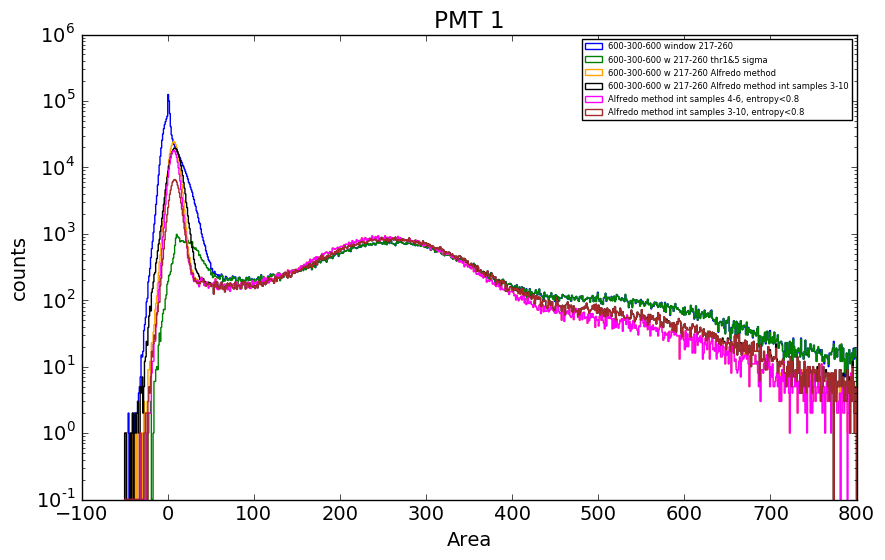

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf4_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf4_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf4_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf4_Gain0_Test_standard_600_300_600.root


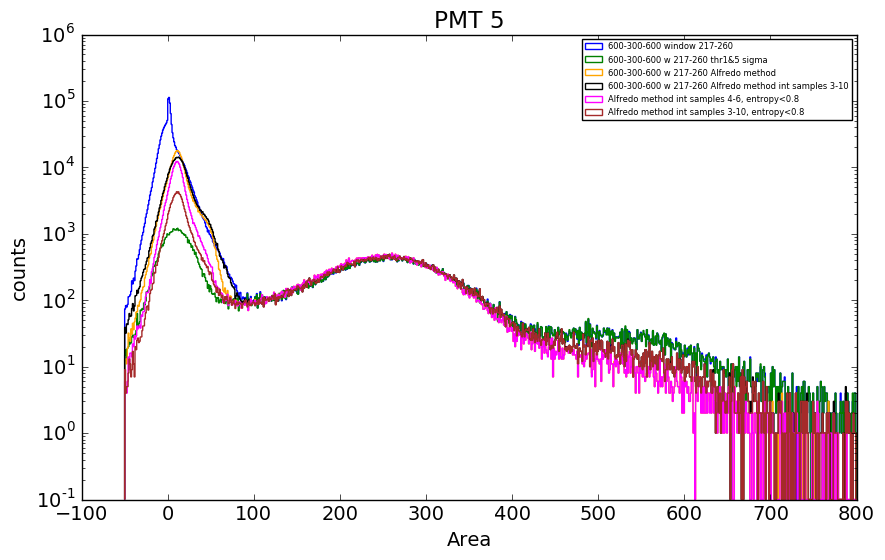

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf0_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf0_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf0_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf0_Gain1_Test_standard_600_300_600.root


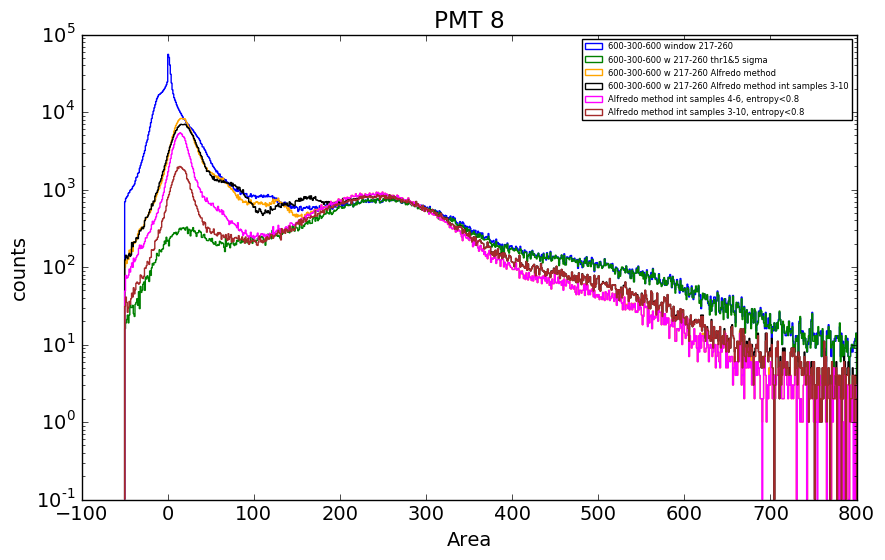

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf2_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf2_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf2_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf2_Gain0_Test_standard_600_300_600.root


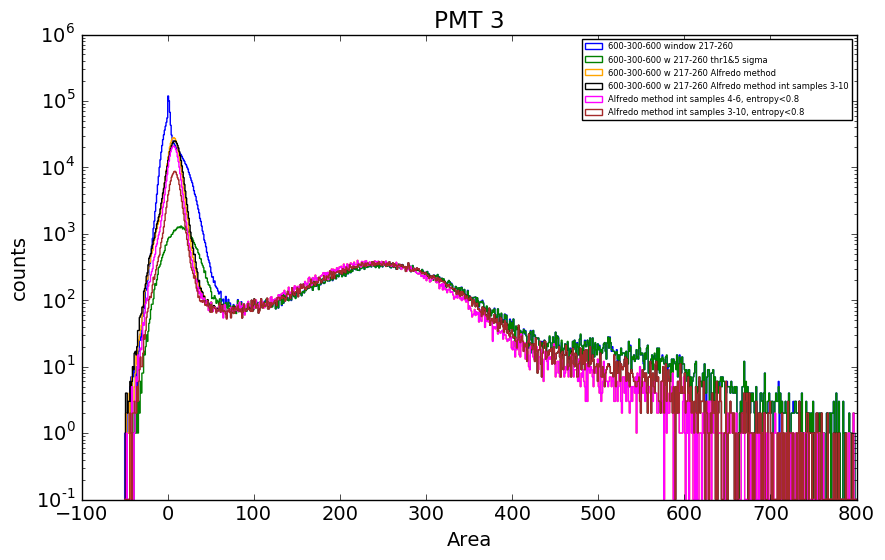

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf3_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf3_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf3_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf3_Gain0_Test_standard_600_300_600.root


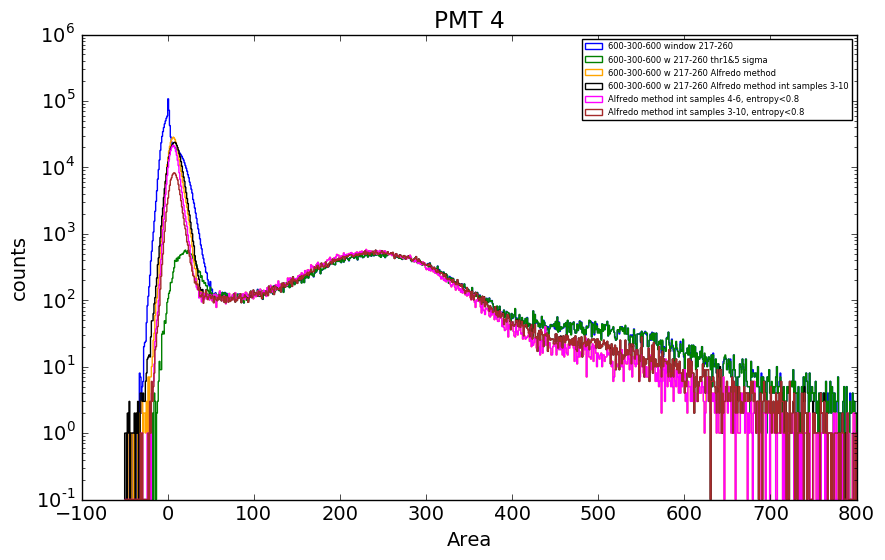

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf1_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf1_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf1_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf1_Gain1_Test_standard_600_300_600.root


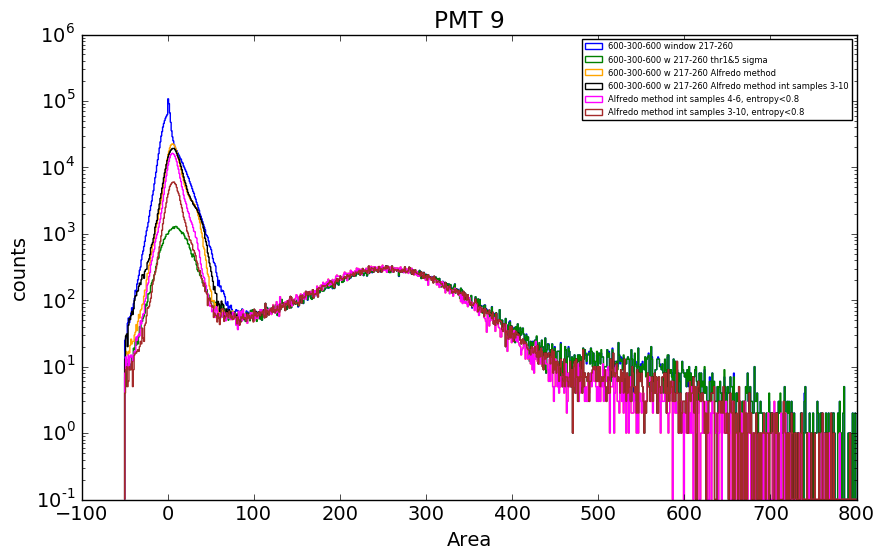

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf3_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf3_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf3_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf3_Gain1_Test_standard_600_300_600.root


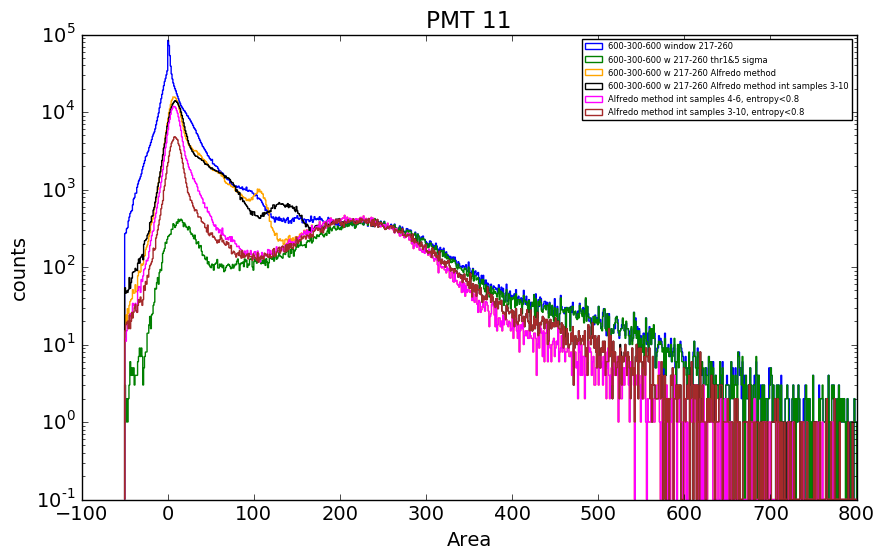

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf4_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf4_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf4_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf4_Gain1_Test_standard_600_300_600.root


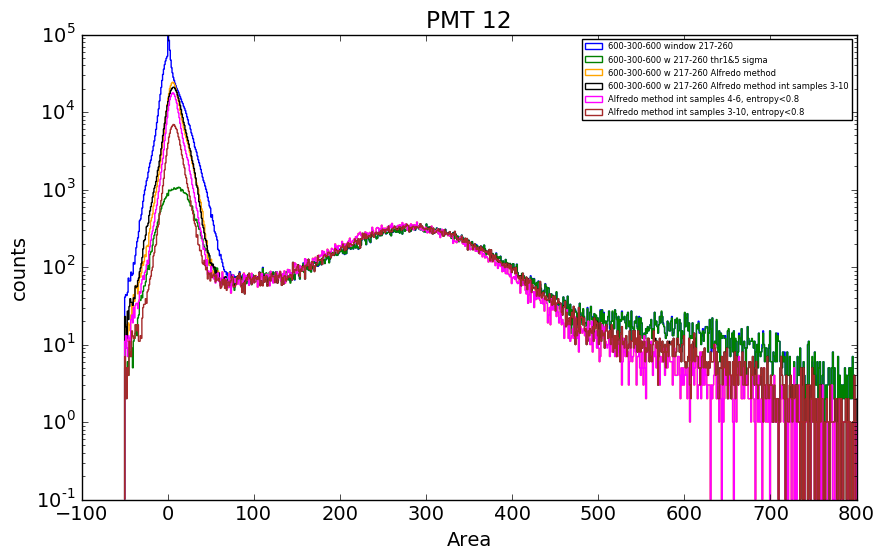

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf2_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf2_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf2_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf2_Gain1_Test_standard_600_300_600.root


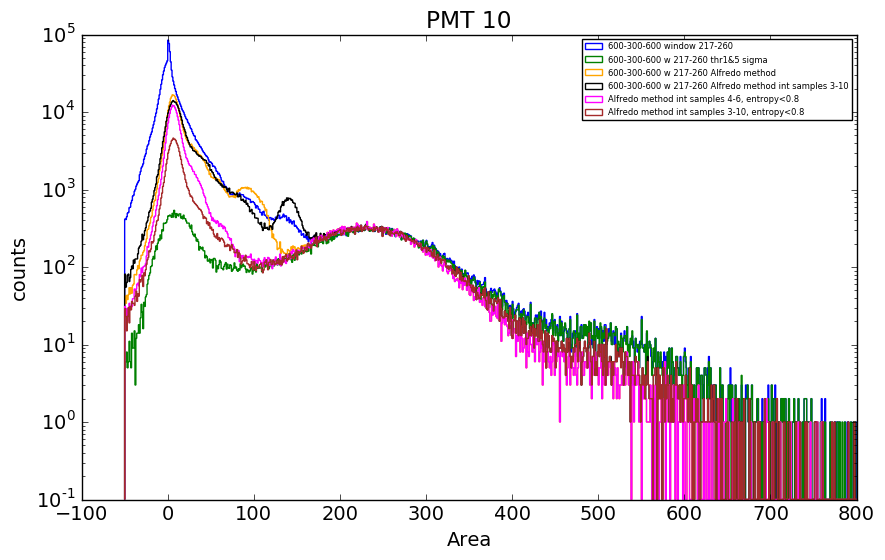

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf5_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf5_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf5_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf5_Gain1_Test_standard_600_300_600.root


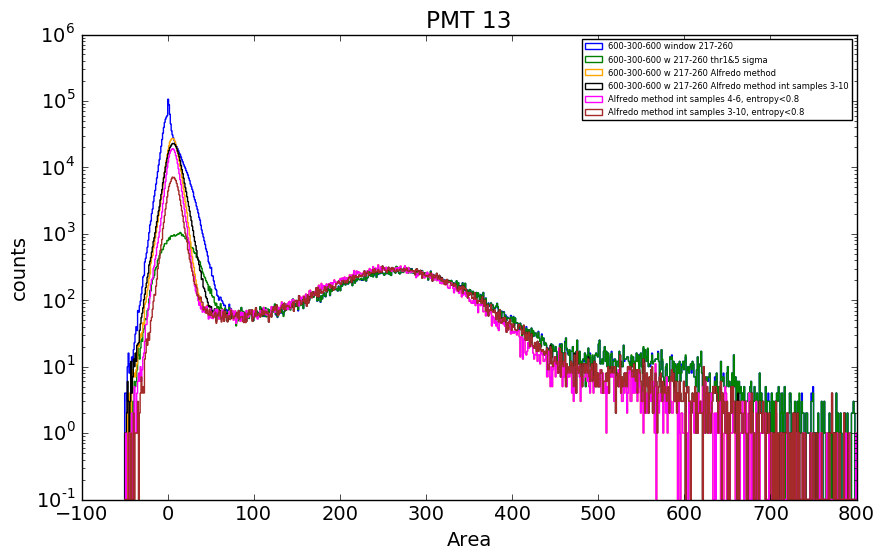

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf5_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf5_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf5_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf5_Gain0_Test_standard_600_300_600.root


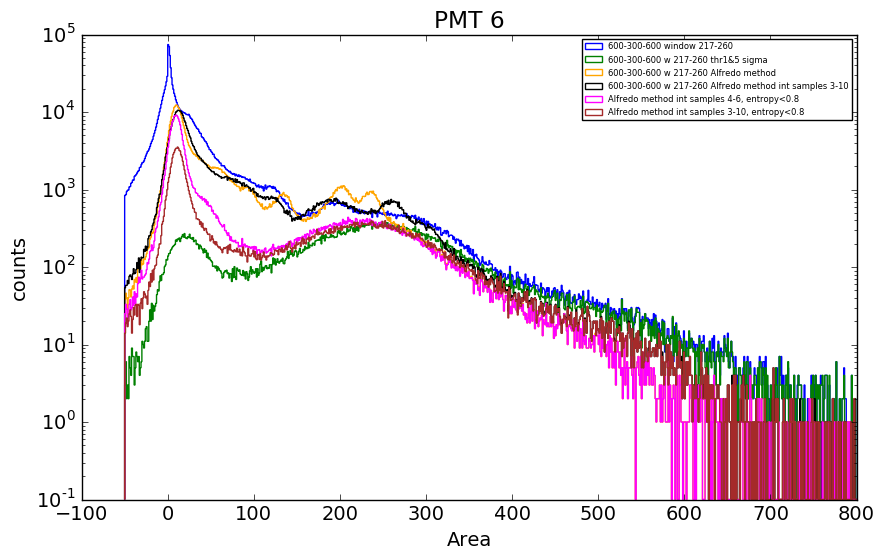

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf6_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf6_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf6_Gain1_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf6_Gain1_Test_standard_600_300_600.root


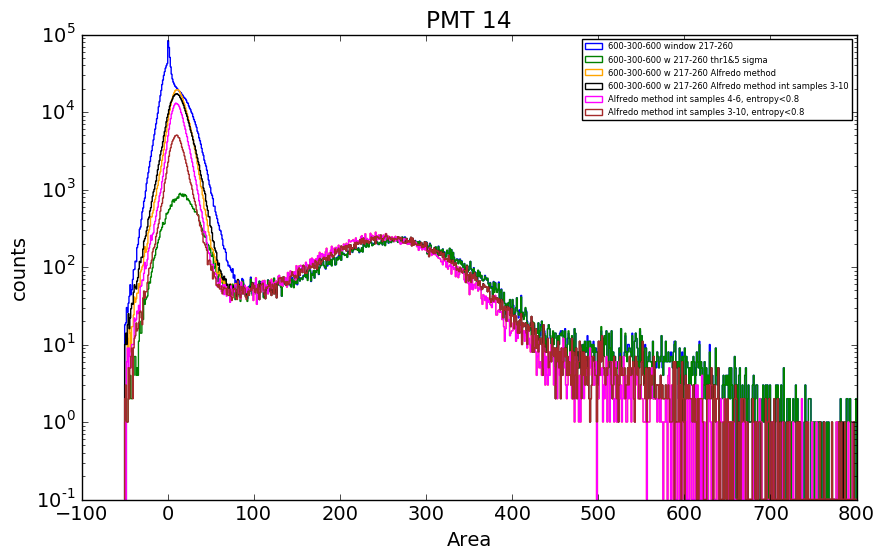

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf6_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf6_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf6_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf6_Gain0_Test_standard_600_300_600.root


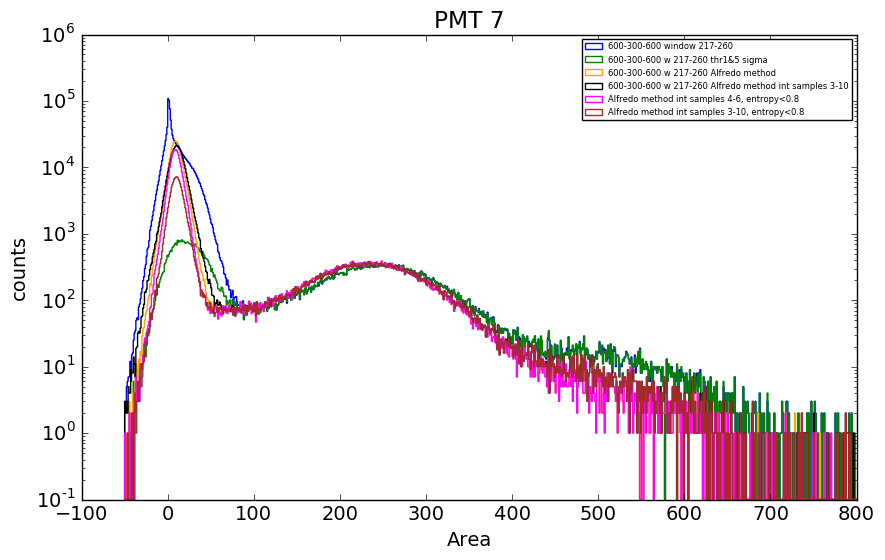

/home/cristian/Suxess_files/data/run5/liquid/gain_study/standard/600-300-600_window217-190/processed_wf1_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/thrs/600-300-600_with_w217-190_thr1-5/processed_wf1_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600/processed_wf1_Gain0_Test_standard_600_300_600.root
/home/cristian/Suxess_files/data/run5/liquid/gain_study/Alfredo_method/600-300-600_i3-10/processed_wf1_Gain0_Test_standard_600_300_600.root


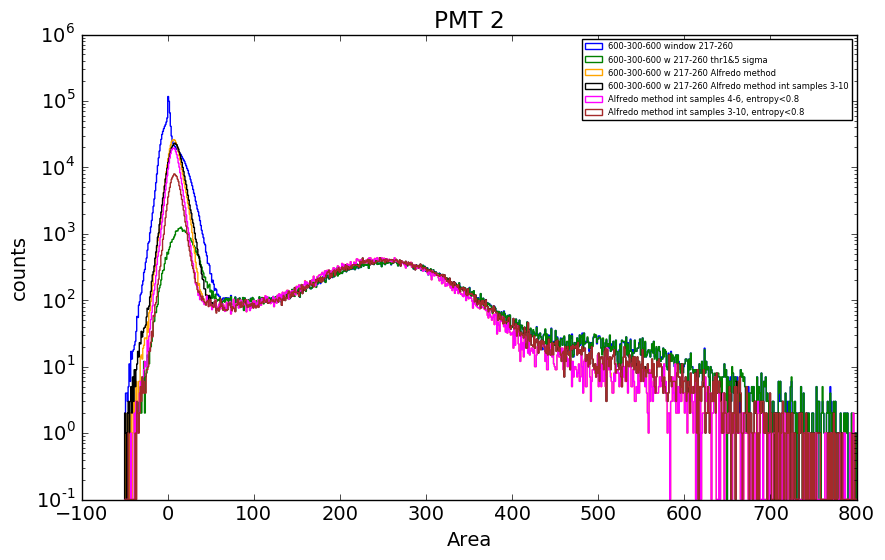

In [31]:
for file in os.listdir(path):
    if 'Figs' in file:
        continue
    print(path+file)
    #channel = int(file.split("_")[1].lstrip("wf"))
    #board = int(file.split("_")[2].lstrip("Board"))
    channel = int(file.split("_")[1].lstrip("wf"))
    board = int(file.split("_")[2].lstrip("Gain"))
    pmt = channel + 1 + board * 7
    file1='processed_wf%d_Gain%d_Test_standard_600_300_600.root' %(channel,board)
    print(path1+file1)
    file2='processed_wf%d_Gain%d_Test_standard_600_300_600.root' %(channel,board)
    print(path2+file2)
    file3='processed_wf%d_Gain%d_Test_standard_600_300_600.root' %(channel,board)
    print(path3+file3)
    #file4='processed_wf%d_Gain%d_Test_standard_600_300_600.root' %(channel,board)
    #print(path4+file4)
    #print(channel,board, pmt)
    #my_regex = r"(processed_wf"+ str(channel) + r"_Board" + str(board) +r"_1300V_LED_*)"
    #for file0 in mypaths1: 
    #    if re.search(my_regex, file0):
    #        file1 = file0
    #print(file1)
    df1 = process_ap_file(path1+file1)
    #for f4 in mypaths2:
    #    if re.search(my_regex, f4) :
    #        file2 = f4

    data = process_ap_file(path+file)
    df2 = process_ap_file(path2+file2)
    df3 = process_ap_file(path3+file3)
    #df4 = process_ap_file(path4+file4)
    #AP_data = AP_data[AP_data['entropy']<0.4]
    plot1dhist(data,df1,df2,df3,pmt,fit_doubleGauss)
    